In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import os
import cv2
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib

from sklearn import preprocessing

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


In [3]:

def load_img(img_path,img_shape, preprocess=True):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path, target_size=(img_rows, img_cols))    
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img, dtype=np.uint8)

In [4]:
def lap_mag(channels):
    laps = []
    print(channels.shape)
    for i in range(channels.shape[-1]):
        
        dst = cv2.Laplacian(channels[:,:,i], cv2.CV_32F , 3)
        laps.append(dst)
    mag = np.linalg.norm(laps, axis = 0)
    return mag

In [5]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [6]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

In [7]:
def local_arg_exrtrema_3(mat1, mat2, mat3):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat1.shape[0]-1):
        for j in range(1, mat1.shape[1]-1):
            pixel_of_interest = mat2[i,j]
            #if np.abs(pixel_of_interest)>2000:
            #print(pixel_of_interest)
            neighbours = mat2[i-1:i+2, j-1:j+2]
            #neighbours[1,1] = np.NaN  #make center nan
            neighbours_above = mat3[i-1:i+2, j-1:j+2]
            neighbours_below = mat1[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours) and pixel_of_interest >= np.max(neighbours_above) and pixel_of_interest >= np.max(neighbours_below)) or (pixel_of_interest <= np.min(neighbours) and pixel_of_interest <= np.min(neighbours_above) and  pixel_of_interest <= np.min(neighbours_below)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)

def local_arg_exrtrema_1(mat):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat.shape[0]-1):
        for j in range(1, mat.shape[1]-1):
            pixel_of_interest = mat[i,j]
            neighbours = mat[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours)) or (pixel_of_interest <= np.min(neighbours)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)   

def local_arg_max(mat, window_size):
    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    k = int(np.floor(window_size/2))
    print(k)
    for i in range(k, mat.shape[0]-k, window_size):
        for j in range(k, mat.shape[1]-k, window_size):

            window = mat[i-k:i+k+1, j-k:j+k+1]
            coords = np.argwhere(window==window.max())
            
            idx.extend(coords + [i-k, j-k])

    return  np.unique(idx, axis=0)   



In [8]:
x = np.array([[1,2,3,75,3,2,1,5,45], [5,7,8,5,11,21,81,6,1] , [3,4,5,43,53,3,9,3,4], [6,34,3,21,3,4,32,3,1], [45,344,2,43,2541,38,3,34,32] , [23,74,343,4,31,97,8, 34,22], [9,7,3,6,4,3,7,2,1]])
x
#np.reshape(x, [-1,4])

array([[   1,    2,    3,   75,    3,    2,    1,    5,   45],
       [   5,    7,    8,    5,   11,   21,   81,    6,    1],
       [   3,    4,    5,   43,   53,    3,    9,    3,    4],
       [   6,   34,    3,   21,    3,    4,   32,    3,    1],
       [  45,  344,    2,   43, 2541,   38,    3,   34,   32],
       [  23,   74,  343,    4,   31,   97,    8,   34,   22],
       [   9,    7,    3,    6,    4,    3,    7,    2,    1]])

In [9]:
local_arg_max(x, 4)

2


array([[4, 4]], dtype=int64)

In [10]:

data_path1= './SYS809_projet2022_sequences1/legumesA-02.jpg'  #'./SYS809_projet2022_sequences1/livre1_old.JPG'
data_path2=  './SYS809_projet2022_sequences1/legumesB-02.jpg'

data_path1= './SYS809_projet2022_sequences1/new_livre1.jpg' #'./SYS809_projet2022_sequences1/new_livre1.JPG'
data_path2='./SYS809_projet2022_sequences1/livre2.jpg' # './SYS809_projet2022_sequences1/livre2.JPG'

img = load_img(data_path1, [224,224])
img_no_proc = load_img(data_path1, [224,224], preprocess=False)





In [11]:
(2**3) #// 2

8

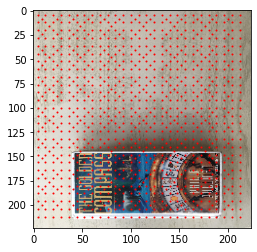

In [14]:
#img = load_img(data_path1,[224,224], preprocess=False)

pool_layers = [3,4,5]

layer_pool_1 = np.stack(get_cnn_out(img, 3))
layer_pool_2 = np.stack(get_cnn_out(img, 6)) 
layer_pool_3 = np.stack(get_cnn_out(img, 10)) 
layer_pool_4 = np.stack(get_cnn_out(img, 14))
layer_pool_5 = np.stack(get_cnn_out(img, 18))

layers = [layer_pool_1,layer_pool_2,layer_pool_3,layer_pool_4,layer_pool_5]

kps=[]
d = []
kp_desc = dict()
#Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
idx = []

for l in pool_layers:
    for i in range(0, layers[l-1].shape[0]-1):
        for j in range(0, layers[l-1].shape[1]-1):

            #window = img[i-k:i+k+1, j-k:j+k+1]
            #coords = np.argwhere(window==window.max())
            row = ((i+.5)) * (2**l)
            col = ((j+.5)) * (2**l) 
            keypoint = cv2.KeyPoint()
            keypoint.pt = (float(row), float(col))
            keypoint.octave = l
            keypoint.size = 0
            keypoint.response = 0
            kps.append(keypoint)
            d.append(layers[l-1][ i, j, : ])


img1_pts = np.float32([ kp.pt for kp in kps])

plt.figure()
plt.imshow(img_no_proc)
plt.scatter(list(list(zip(*img1_pts))[0]), list(list(zip(*img1_pts))[1]), s=[1], c='r')


In [13]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)

#Le champ .pt des object KeyPoint contiennent la position du point-cle

plt.imshow(cv2.drawKeypoints(img,kp1,None))

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\features2d\src\sift.dispatch.cpp:477: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'cv::SIFT_Impl::detectAndCompute'


In [ ]:
d

[array([6.80327209e+02, 9.09044739e+02, 5.59695862e+02, 6.65300842e+02,
        8.93747803e+02, 0.00000000e+00, 1.70407730e+02, 0.00000000e+00,
        4.97900970e+02, 3.16966217e+02, 5.09923737e+02, 2.28395096e+02,
        8.40793457e+02, 1.48167395e+03, 2.15915421e+02, 0.00000000e+00,
        4.01513367e+02, 3.89340332e+02, 3.54783997e+02, 7.70151550e+02,
        2.46396942e+02, 5.27531311e+02, 1.23216461e+02, 2.87072449e+02,
        4.53316437e+02, 2.27262024e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18451733e+03,
        0.00000000e+00, 5.95535278e+02, 0.00000000e+00, 1.59074326e+02,
        3.24278069e+00, 1.34014990e+03, 1.00024307e+02, 0.00000000e+00,
        3.43825348e+02, 0.00000000e+00, 0.00000000e+00, 8.02302979e+02,
        2.09114014e+02, 1.61168137e+02, 5.35282227e+02, 8.67212219e+01,
        2.95570923e+02, 2.68816040e+02, 5.24390442e+02, 0.00000000e+00,
        3.24003815e+02, 2.82045013e+02, 6.55593213e+03, 0.000000